# Big Data Platform
## Assignment 3: ServerLess

# Question 0n

## Setup
<strong> 
1. Navigate to IBM Cloud and open a trial account. No need to provide a credit card
2. Choose IBM Cloud Object Storage service from the catalog
3. Create a new bucket in IBM Cloud Object Storage
4. Create credentials for the bucket with HMAC (access key and secret key)
5. Choose IBM Cloud Functions service from the catalog and create a service
</strong> 

Instead of IBM Cloud, we decided to work with AWS where we can use S3 as cloud object storage service and Lambda functions as a serverless functions service. 

#### IBM Cloud Object Storage setup
<strong> 1. Upload all the input CSV files that you used in homework 2 into the bucket you created in IBM Cloud Object Storage </strong>

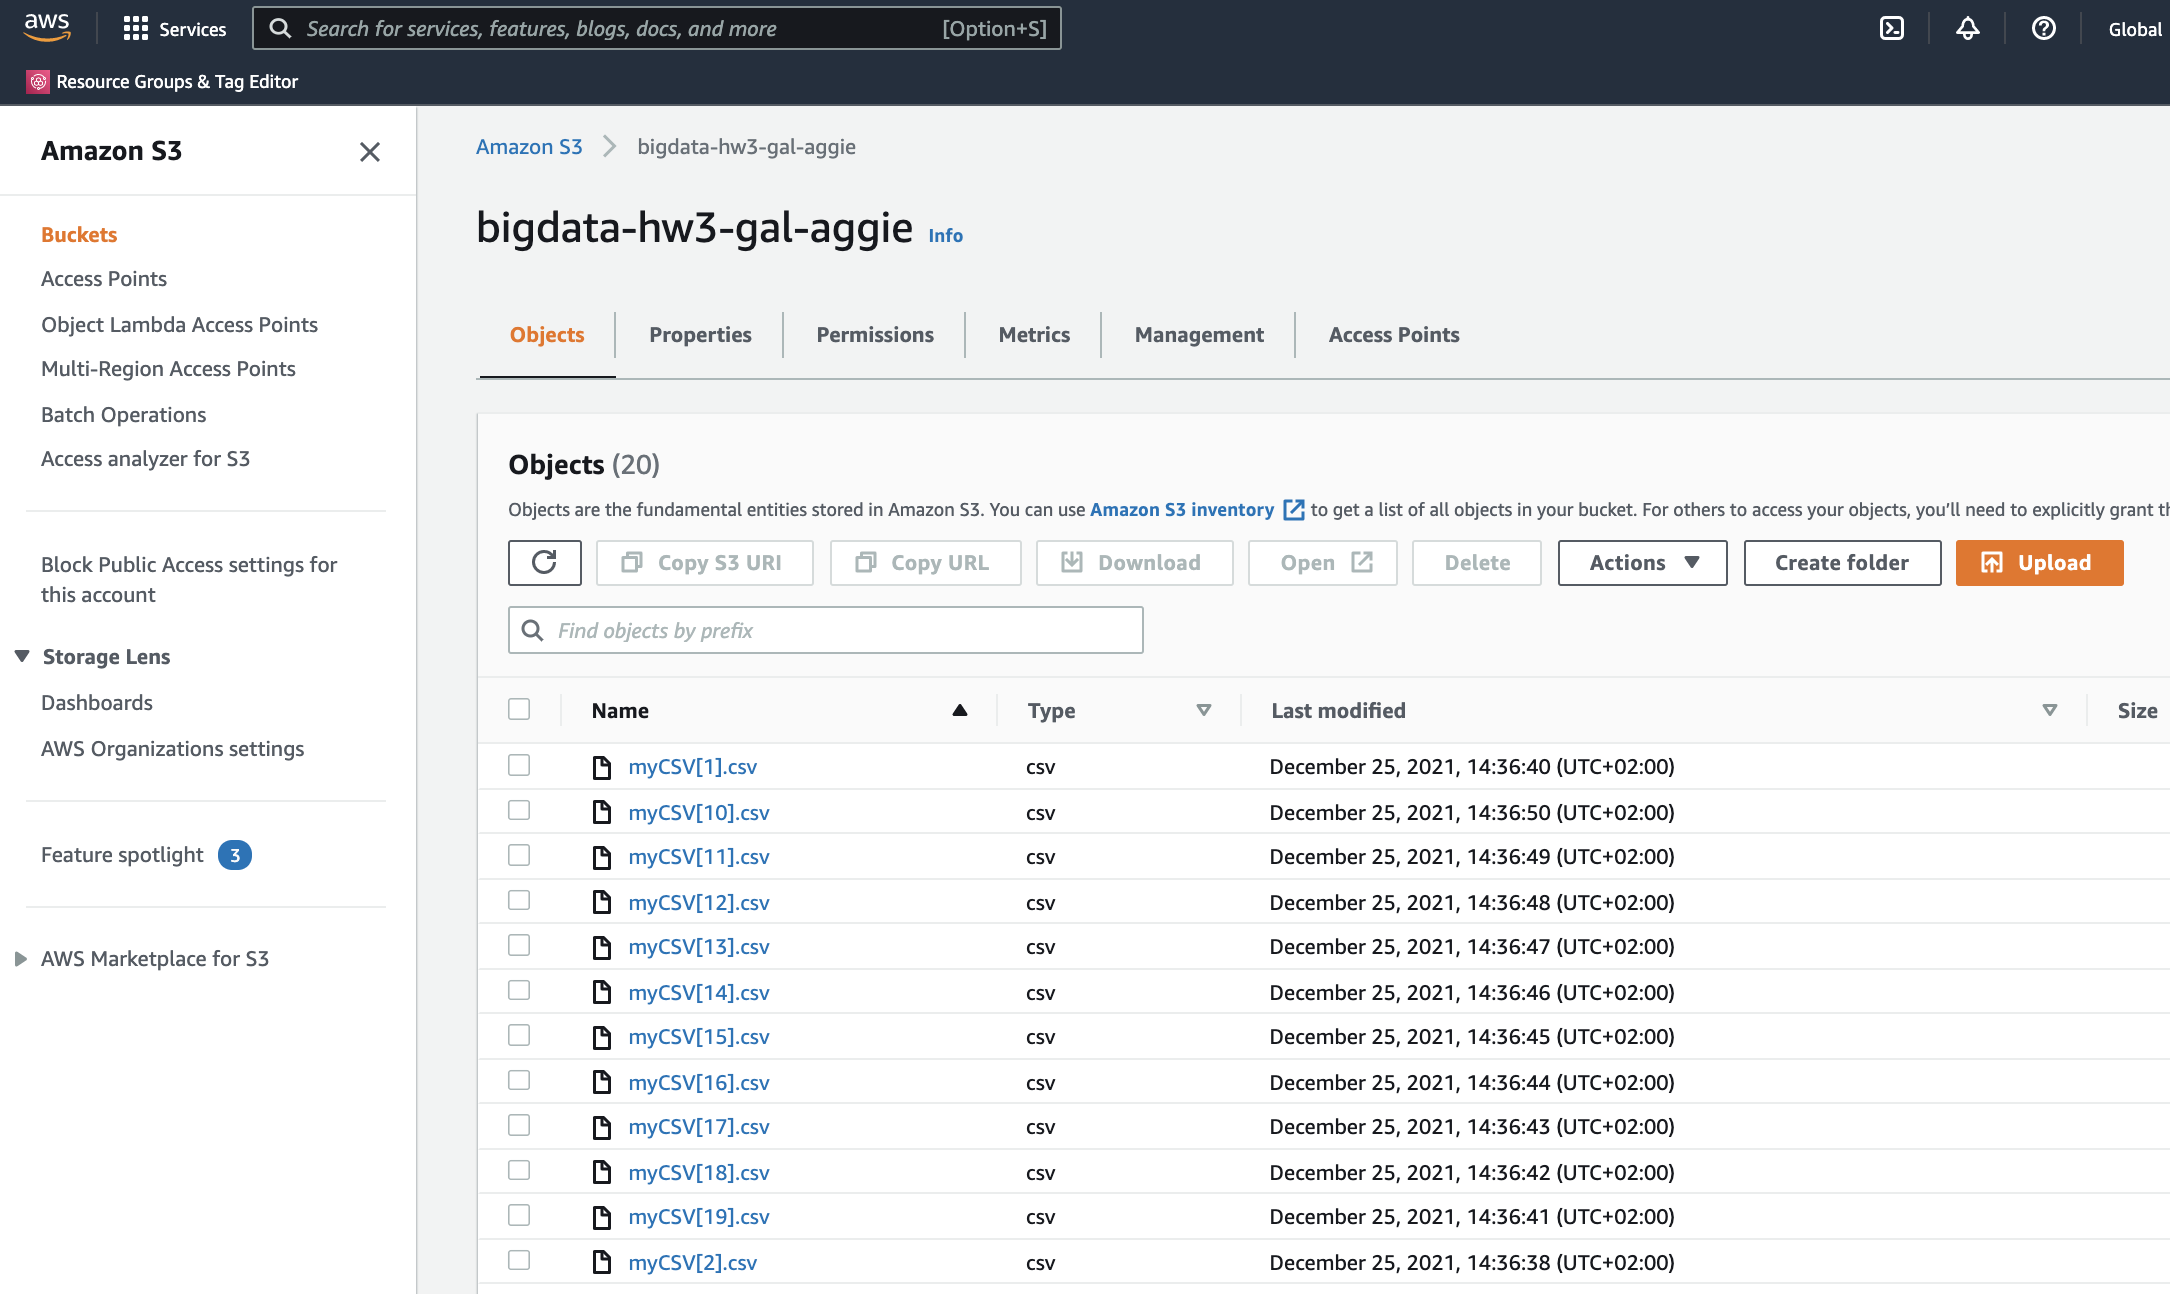

#### Lithops setup<strong> 
1. By using “git” tool, install master branch of the Lithops project from
https://github.com/lithops-cloud/lithops 
2. Follow Lithops documentation and configure Lithops against IBM Cloud Functions and IBM Cloud Object Storage </strong>


In [ ]:
%%capture
#!pip install lithops
!pip install boto3
!pip install git+https://github.com/lithops-cloud/lithops.git

In [ ]:
import lithops
import boto3
import pandas as pd

3. Configure Lithops log level to be in DEBUG mode

In [ ]:
config = {
    'lithops': {'backend': 'aws_lambda', 
                'storage': 'aws_s3',
                'log_level': 'DEBUG'},
    'aws':  {'access_key_id': 'xx',
             'secret_access_key': 'xxx',
             'account_id': '170091767549'},
    'aws_s3': {'storage_bucket': 'bigdata-hw3-gal-aggie',
               'region_name': 'us-east-1'},
    'aws_lambda': {'execution_role': 'arn:aws:iam::170091767549:role/bigdata-hw3-gal-aggie-role',
                'region_name': 'us-east-1'}
}       
# Using https://lithops-cloud.github.io/docs/source/storage_config/aws_s3.html        
# https://lithops-cloud.github.io/docs/source/configuration.html

4. Run Hello World example by using Futures API and verify all is working properly.

In [ ]:
def hello(name):
    return 'Hello {}!'.format(name)

with lithops.FunctionExecutor(log_level='DEBUG') as fexec:
    fut = fexec.call_async(hello, 'World')
    print(fut.result())

2022-01-09 10:10:46,002 [INFO] lithops.config -- Lithops v2.5.9.dev0
2022-01-09 10:10:46,006 [DEBUG] lithops.config -- Config file not found
2022-01-09 10:10:46,010 [DEBUG] lithops.config -- Loading compute backend module: localhost
2022-01-09 10:10:46,014 [DEBUG] lithops.config -- Loading Storage backend module: localhost
2022-01-09 10:10:46,020 [DEBUG] lithops.storage.backends.localhost.localhost -- Creating Localhost storage client
2022-01-09 10:10:46,024 [INFO] lithops.storage.backends.localhost.localhost -- Localhost storage client created
2022-01-09 10:10:46,027 [DEBUG] lithops.localhost.localhost -- Creating Localhost compute client
2022-01-09 10:10:46,031 [INFO] lithops.localhost.localhost -- Localhost compute client created
2022-01-09 10:10:46,035 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-0 - Invoker initialized. Max workers: 1
2022-01-09 10:10:46,036 [DEBUG] lithops.executors -- Function executor for localhost created with ID: 02d5ba-0
2022-01-09 10:10:46,040 [INFO] litho

Hello World!


# Question 1
## Serverless MapReduceEngine

<strong> Modify MapReduceEngine from homework 2 into the MapReduceServerlessEngine where map and reduce tasks executed as a serverless actions, instead of local threads. In particular:
1. Deploy all map tasks as a serverless actions by using Lithops against IBM Cloud Functions.
2. Collect results from all map tasks and store them in the same SQLite as you used in MapReduceEngine and use the same code for the sort and shuffle phase.
3. Deploy reduce tasks by using Lithops against IBM Cloud Functions. Instead of persisting results from reduce tasks, return results back to the MapReduceServerlessEngine and proceed with the same workflow as in MapReduceEngine
4. Return results of reduce tasks to the user

**Please attach:**  
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.
</strong>


Create an SQLite3 database and table to use in MapReduceEngine

In [ ]:
import sqlite3

# initialize a connection object
conn = None

# open / create new database
try:
    conn = sqlite3.connect("mydb.db")

except Error as e:
    print(e)

# if it opens without errors, 
finally:

    if conn:
      # create a new table and execute the statement
      cursor = conn.cursor()
      create_table_statement = ''' CREATE TABLE IF NOT EXISTS temp_results(key TEXT, value TEXT)'''
      cursor.execute(create_table_statement)
      conn.commit()
      conn.close()

Modify MapReduceEngine from HW 2 into the MapReduceServerlessEngine so that all map and reduce tasks are executed as a serverless actions:

In [ ]:
class MapReduceServerlessEngine():

  '''
  input_data: array of elements [‘s3://bucket-name/myCSV1.csv’,.. ,‘s3://bucket-name/myCSV20.csv’]
  map_function: a pointer to the function that returns a list where each entry of the form (key,value)
  reduce_function: a pointer to the function that returns a list where each entry of the form (key,value)
  params: parameters to the map_function of the form params={key:value}
  '''
  @staticmethod
  def execute(input_data, map_function, reduce_function, params):

    global column_index
    column_index = params['column']

    print('STARTING MAP...')

    # Deploy all map tasks as a serverless actions by using Lithops against AWS Lambda
    with lithops.ServerlessExecutor(config=config, log_level='DEBUG') as serverless_exec:
      serverless_exec.map(map_function, input_data)

      # Collect results from all map tasks
      map_results = serverless_exec.get_result()
    #print(map_results)

    print('STORING MAP RESULTS LOCALLY..')

    # Store map results in SQLite and use the same code for the sort and shuffle phase
    conn = sqlite3.connect("mydb.db")
    cur = conn.cursor()

    # for every file results
    for file_res in map_results:

      # for every entry in the result
      for entry in file_res:
        key = entry[0]
        value = entry[1]

        # form insert statement 
        cur.execute("INSERT INTO temp_results VALUES(?, ?)", (key, value))

    conn.commit()

    db_df = pd.read_sql_query("SELECT key, GROUP_CONCAT(value) as value FROM temp_results GROUP BY key ORDER BY key", conn)
    reduce_input = list(map(tuple, db_df.to_records(index=False)))

    conn.close()

    print('STARTING REDUCE...')

    #Deploy reduce tasks by using Lithops against IBM Cloud Functions
    with lithops.ServerlessExecutor(config=config, log_level='DEBUG') as serverless_exec:
        serverless_exec.map(reduce_function, reduce_input)
        reduce_results = serverless_exec.get_result() 
    return reduce_results

Define map and reduce tasks executed as a serverless actions

In [ ]:
# Read cloud object, return a list that contains entries: (key_value, document_name) for the specific column index provided
# https://lithops-cloud.github.io/docs/source/data_processing.html
def inverted_map(obj):

  bucket_name = obj.bucket
  key = obj.key
  data = obj.data_stream.read()

  # list that contains entries of the form (key_value, document_name)
  results = []

  # for every line in the file
  for line in data.splitlines():

    # split from decoding
    for word in line.decode('utf-8').split():

      # split by ,
      row_values = word.split(',')

      # extract the column to map
      map_value = row_values[column_index-1] #-1 because index starts at 0

      # create a tuple and append to results
      entry = (map_value, key)
      results.append(entry)

  # [('John', '/bucket-name/myCSV[1].csv'), ('Albert', '/name/myCSV[1].csv'), ...]
  return results[1:]

# documents is a list of CSV documents per given key (might have duplicates)
# Return a new list without duplicates
def inverted_reduce(key, documents):

  # remove duplicates by creating a dictionary using list items as keys
  documents = documents.split(",")
  documents = list(set(documents))
  return (key, documents)

# Task 2
## Submit MapReduce job to calculate inverted index
1. Use input_data: `cos://bucket/<path to CSV data>`
2. Submit MapReduce job with reduce and map functions as you used in homework 2, as follows

    `mapreduce = MapReduceServerlessEngine()`  
    `results = mapreduce.execute(input_data, inverted_map, inverted_index)`   
    `print(results)`

**Please attach:**  
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

In [ ]:
input_data = ['bigdata-hw3-gal-aggie/data/']

mapreduce = MapReduceServerlessEngine()
# params= column:1 for first_name, column:2 for second_name, column:3 for city
results = mapreduce.execute(input_data, inverted_map, inverted_reduce, params={'column':1})
print('FINAL MAP REDUCE RESULTS: ' + str(results))

2022-01-09 10:10:47,982 [INFO] lithops.config -- Lithops v2.5.9.dev0
2022-01-09 10:10:47,984 [DEBUG] lithops.config -- Loading Serverless backend module: aws_lambda
2022-01-09 10:10:47,990 [DEBUG] lithops.config -- Loading Storage backend module: aws_s3
2022-01-09 10:10:47,994 [DEBUG] lithops.storage.backends.aws_s3.aws_s3 -- Creating S3 client


STARTING MAP...


2022-01-09 10:10:48,090 [INFO] lithops.storage.backends.aws_s3.aws_s3 -- S3 client created - Region: us-east-1
2022-01-09 10:10:48,092 [DEBUG] lithops.serverless.backends.aws_lambda.aws_lambda -- Creating AWS Lambda client
2022-01-09 10:10:48,094 [DEBUG] lithops.serverless.backends.aws_lambda.aws_lambda -- Creating Boto3 AWS Session and Lambda Client
2022-01-09 10:10:48,179 [INFO] lithops.serverless.backends.aws_lambda.aws_lambda -- AWS Lambda client created - Region: us-east-1
2022-01-09 10:10:48,183 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-1 - Invoker initialized. Max workers: 1000
2022-01-09 10:10:48,186 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-1 - Serverless invoker created
2022-01-09 10:10:48,188 [DEBUG] lithops.executors -- Function executor for aws_lambda created with ID: 02d5ba-1
2022-01-09 10:10:48,190 [INFO] lithops.invokers -- ExecutorID 02d5ba-1 | JobID M000 - Selected Runtime: python37 - 256MB
2022-01-09 10:10:48,192 [DEBUG] lithops.storage.storage -- Runtime met

STORING MAP RESULTS LOCALLY..


2022-01-09 10:10:52,585 [INFO] lithops.config -- Lithops v2.5.9.dev0
2022-01-09 10:10:52,587 [DEBUG] lithops.config -- Loading Serverless backend module: aws_lambda
2022-01-09 10:10:52,590 [DEBUG] lithops.config -- Loading Storage backend module: aws_s3
2022-01-09 10:10:52,592 [DEBUG] lithops.storage.backends.aws_s3.aws_s3 -- Creating S3 client
2022-01-09 10:10:52,605 [INFO] lithops.storage.backends.aws_s3.aws_s3 -- S3 client created - Region: us-east-1
2022-01-09 10:10:52,608 [DEBUG] lithops.serverless.backends.aws_lambda.aws_lambda -- Creating AWS Lambda client
2022-01-09 10:10:52,611 [DEBUG] lithops.serverless.backends.aws_lambda.aws_lambda -- Creating Boto3 AWS Session and Lambda Client
2022-01-09 10:10:52,734 [INFO] lithops.serverless.backends.aws_lambda.aws_lambda -- AWS Lambda client created - Region: us-east-1
2022-01-09 10:10:52,741 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-2 - Invoker initialized. Max workers: 1000
2022-01-09 10:10:52,744 [DEBUG] lithops.invokers -- Execu

STARTING REDUCE...


2022-01-09 10:10:52,792 [DEBUG] lithops.job.job -- ExecutorID 02d5ba-2 | JobID M000 - Uploading function and modules to the storage backend
2022-01-09 10:10:52,949 [DEBUG] lithops.storage.backends.aws_s3.aws_s3 -- PUT Object lithops.jobs/02d5ba-2/af69b6073dae495a45e226cae0a1904b.func.pickle - Size: 527.0B - OK
2022-01-09 10:10:52,952 [DEBUG] lithops.job.job -- ExecutorID 02d5ba-2 | JobID M000 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 10:10:52,961 [INFO] lithops.invokers -- ExecutorID 02d5ba-2 | JobID M000 - Starting function invocation: inverted_reduce() - Total: 8 activations
2022-01-09 10:10:52,963 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-2 | JobID M000 - Worker processes: 1 - Chunksize: 1
2022-01-09 10:10:52,965 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-2 - Async invoker 0 started
2022-01-09 10:10:52,970 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-2 - Async invoker 1 started
2022-01-09 10:10:52,972 [DEBUG] lithops.invokers -- Ex

FINAL MAP REDUCE RESULTS: [('Albert', ['data/myCSV[16].csv', 'data/myCSV[12].csv', 'data/myCSV[6].csv', 'data/myCSV[4].csv', 'data/myCSV[20].csv', 'data/myCSV[10].csv', 'data/myCSV[19].csv', 'data/myCSV[18].csv', 'data/myCSV[1].csv', 'data/myCSV[14].csv', 'data/myCSV[5].csv', 'data/myCSV[11].csv', 'data/myCSV[7].csv', 'data/myCSV[9].csv', 'data/myCSV[17].csv']), ('Dana', ['data/myCSV[16].csv', 'data/myCSV[13].csv', 'data/myCSV[4].csv', 'data/myCSV[1].csv', 'data/myCSV[3].csv', 'data/myCSV[9].csv', 'data/myCSV[2].csv', 'data/myCSV[11].csv', 'data/myCSV[5].csv', 'data/myCSV[8].csv', 'data/myCSV[6].csv', 'data/myCSV[17].csv', 'data/myCSV[14].csv', 'data/myCSV[10].csv', 'data/myCSV[19].csv', 'data/myCSV[15].csv']), ('Johanna', ['data/myCSV[20].csv', 'data/myCSV[5].csv', 'data/myCSV[16].csv', 'data/myCSV[19].csv', 'data/myCSV[7].csv', 'data/myCSV[18].csv', 'data/myCSV[9].csv', 'data/myCSV[2].csv', 'data/myCSV[10].csv', 'data/myCSV[8].csv', 'data/myCSV[12].csv', 'data/myCSV[3].csv', 'data/my

2022-01-09 10:10:56,194 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-2 - Async invoker 1 finished
2022-01-09 10:10:56,196 [DEBUG] lithops.invokers -- ExecutorID 02d5ba-2 - Async invoker 0 finished


It is interesting that the results are treated throughout the processing as a list of lists:

In [ ]:
for sub_list in results:
  print(sub_list) 

('Albert', ['data/myCSV[16].csv', 'data/myCSV[12].csv', 'data/myCSV[6].csv', 'data/myCSV[4].csv', 'data/myCSV[20].csv', 'data/myCSV[10].csv', 'data/myCSV[19].csv', 'data/myCSV[18].csv', 'data/myCSV[1].csv', 'data/myCSV[14].csv', 'data/myCSV[5].csv', 'data/myCSV[11].csv', 'data/myCSV[7].csv', 'data/myCSV[9].csv', 'data/myCSV[17].csv'])
('Dana', ['data/myCSV[16].csv', 'data/myCSV[13].csv', 'data/myCSV[4].csv', 'data/myCSV[1].csv', 'data/myCSV[3].csv', 'data/myCSV[9].csv', 'data/myCSV[2].csv', 'data/myCSV[11].csv', 'data/myCSV[5].csv', 'data/myCSV[8].csv', 'data/myCSV[6].csv', 'data/myCSV[17].csv', 'data/myCSV[14].csv', 'data/myCSV[10].csv', 'data/myCSV[19].csv', 'data/myCSV[15].csv'])
('Johanna', ['data/myCSV[20].csv', 'data/myCSV[5].csv', 'data/myCSV[16].csv', 'data/myCSV[19].csv', 'data/myCSV[7].csv', 'data/myCSV[18].csv', 'data/myCSV[9].csv', 'data/myCSV[2].csv', 'data/myCSV[10].csv', 'data/myCSV[8].csv', 'data/myCSV[12].csv', 'data/myCSV[3].csv', 'data/myCSV[13].csv', 'data/myCSV[1].

# Question 3
## Shuffle

MapReduceServerlessEngine deploys both map and reduce tasks as serverless invocations.   
However, once map stage completed, the result are transferred from the map tasks to the SQLite database located on the client machine (laptop in your case), then performed local shuffle and then invoked reduce tasks passing them relevant parameters.

(To support your answers, feel free to use examples, Images, etc.)

**1. Explain why this approach is not efficient and what are cons and pros of such architecture in general. In broader scope you may assume that MapReduceServerlessEngine executed in some powerful machine and not just laptop.**

The disadvantage of such an approach is that the engine is limited by the amount of local storage available for the shuffle phase. As well, transferring the intermediate data from local storage back to the server can create additional points of failure.
However, the advantages of this architecture is that the intermediate output from the map function is saved locally rather than on the server. The map function output is not meaningful to the user, and storing it on the server is an involved process that also requires purchasing more serverless functionality. As well, in case of failure, removing the intermediate results from the server would be a difficult and tedious process.

**2. Suggest how can you improve shuffle so intermediate data will not be downloaded to the client at all and shuffle performed in the cloud as well. Explain pros and cons of the approaches you suggest.**


One way to improve shuffle is to use a serverless database, such as DynamoDB. The advantage of this is that we no longer need to worry about the local storage capacity, as serverless storage are continuously scalable. The cons of this is that this will increase costs (as serverless platforms charge per use), and considering map function output a lot of intermediate data, this can create a significant cost increase. Another con is that most serverless databases are not relational, while many users may desire a relational database for their purposes.
Another approach is to use a relational database on the cloud, such as Cloud SQL from Google. This will have the same advantages as previously, but will also be a relational database. A disadvantage to both approaches is that the shuffle stage will take longer, as communication between the cloud services is likely to be slower than accessing the intermediate data on disk.

**3. Can you make serverless shuffle?**


Yes - for example, if you store all intermediate <key, value> pairs from the map function in an S3 bucket, they can later be accessed by the serverless reducer invocation.
We can alter our code to have new functions that will perform the shuffle phase, without the use of the local SQL database.
